In [6]:


import numpy as np
import pandas as pd
from scipy.optimize import minimize
import pandas as pd
import numpy as np
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt


# === Dane wejściowe ===
def load_data(base_dir, sample_n=50):
    all_data = []
    tickers_seen = set()
    for root, _, files in os.walk(base_dir):
        np.random.shuffle(files)
        for file in files:
            if file.endswith(".csv"):
                path = os.path.join(root, file)
                try:
                    ticker = os.path.splitext(file)[0]
                    if ticker in tickers_seen:
                        continue
                    df = pd.read_csv(path, skiprows=2, header=None,
                                     names=["Date", "Close", "High", "Low", "Open", "Volume"],
                                     usecols=["Date", "Close"])
                    df["Date"] = pd.to_datetime(df["Date"], format="%Y-%m-%d", errors="coerce")
                    df = df.dropna(subset=["Date", "Close"])
                    if df.shape[0] > 100:
                        df["TICKER"] = ticker
                        all_data.append(df)
                        tickers_seen.add(ticker)
                        if len(tickers_seen) >= sample_n:
                            break
                except Exception:
                    continue
        if len(tickers_seen) >= sample_n:
            break
    if not all_data:
        raise Exception("Brak danych")
    return pd.concat(all_data, ignore_index=True)

def prepare_pivot(df, start_year=2020, end_year=2025, max_nan_percent=5.0):
    df = df[(df["Date"].dt.year >= start_year) & (df["Date"].dt.year <= end_year)]
    pivot = df.pivot(index="Date", columns="TICKER", values="Close").sort_index()
    pivot = pivot[pivot.index.weekday < 5]
    nans = pivot.isna().sum() / len(pivot) * 100
    good_tickers = nans[nans <= max_nan_percent].index.tolist()
    pivot = pivot[good_tickers].fillna(method="ffill").fillna(method="bfill")
    return pivot


In [ ]:

def diversification_ratio(w, sigma, cov):
    numerator = np.dot(w, sigma)
    denominator = np.sqrt(np.dot(w.T, np.dot(cov, w)))
    return numerator / denominator if denominator > 1e-8 else 0

def optimize_mdpp_scaled(mu, sigma, cov, lambda1=0.5, lambda2=0.3, w0=None):
    n = len(mu)
    if w0 is None:
        w0 = np.ones(n) / n

   
    dr0 = diversification_ratio(w0, sigma, cov)
    ret0 = np.dot(mu, w0)
    var0 = np.dot(w0.T, np.dot(cov, w0))

    def objective(w):
        dr = diversification_ratio(w, sigma, cov) / (dr0 + 1e-8)
        ret = np.dot(w, mu) / (np.abs(ret0) + 1e-8)
        var = np.dot(w.T, np.dot(cov, w)) / (np.abs(var0) + 1e-8)
        return -(dr + lambda1 * ret - lambda2 * var)

    bounds = [(0, 1) for _ in range(n)]
    constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1}]
    result = minimize(objective, w0, bounds=bounds, constraints=constraints, method='SLSQP')
    return result.x if result.success else w0


def rolling_test_mdpp_scaled(df, start_test, end_test, window_size, lambda1, lambda2,
                              initial_capital=1.0, trading_cost=0.001, rebalance_freq=5):
    df = df.loc[:end_test]
    test_dates = df.loc[start_test:end_test].index
    n_assets = df.shape[1]

    portfolio_value = pd.Series(index=test_dates, dtype=float)
    weights_history = pd.DataFrame(index=test_dates, columns=df.columns, dtype=float)

    capital = initial_capital
    w_prev = np.ones(n_assets) / n_assets  # start z równymi wagami

    for i, current_date in enumerate(test_dates):
        if i < window_size:
            if i > 0:
                today_prices = df.loc[current_date].values
                yesterday_prices = df.loc[test_dates[i - 1]].values
                ret_vector = today_prices / yesterday_prices - 1
                capital *= (1 + np.dot(w_prev, ret_vector))
            portfolio_value[current_date] = capital
            weights_history.loc[current_date] = w_prev
            continue

        if i % rebalance_freq == 0:
            window_data = df.loc[:current_date].iloc[-window_size:]
            returns = window_data.pct_change().dropna()
            mu = returns.mean().values
            sigma = returns.std().values

            # Ledoit-Wolf shrinkage
            lw = LedoitWolf()
            cov = lw.fit(returns.values).covariance_

            w_opt = optimize_mdpp_scaled(mu, sigma, cov, lambda1, lambda2, w_prev)
        else:
            w_opt = w_prev

        if i > 0:
            today_prices = df.loc[current_date].values
            yesterday_prices = df.loc[test_dates[i - 1]].values
            ret_vector = today_prices / yesterday_prices - 1
            gross_return = np.dot(w_prev, ret_vector)
            turnover = np.sum(np.abs(w_opt - w_prev)) if i % rebalance_freq == 0 else 0
            net_return = gross_return - trading_cost * turnover
            capital *= (1 + net_return)

        portfolio_value[current_date] = capital
        weights_history.loc[current_date] = w_opt
        w_prev = w_opt.copy()

    return portfolio_value, weights_history


In [8]:
base_dir = r"C:\Users\Basia\Do przejrzenia\am_sem2\mgr\kody\downloaded_data"

df_all = load_data(base_dir, sample_n=777)
pivot_df = prepare_pivot(df_all)

C:\Users\Basia\AppData\Local\Temp\ipykernel_20300\1485184819.py:57: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  pivot = pivot[good_tickers].fillna(method="ffill").fillna(method="bfill")


<Axes: xlabel='Date'>

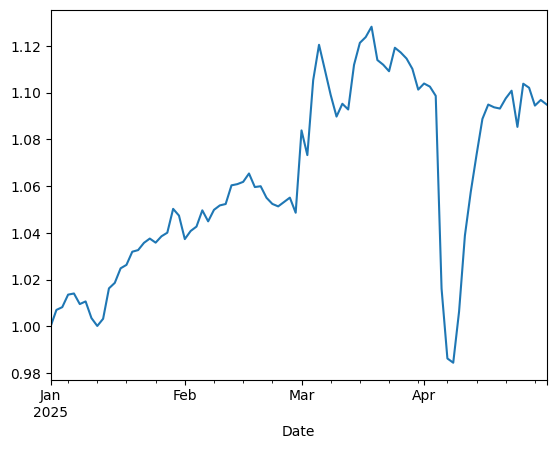

In [ ]:


capital_series_final, weights_df_final = rolling_test_mdpp_scaled(
    df=pivot_df,
    start_test="2025-01-01",
    end_test="2025-04-30",
    window_size=20,
    lambda1=0.5,
    lambda2=1,
    initial_capital=1.0,
    trading_cost=0.001,
    rebalance_freq=5
)

capital_series_final.to_csv("mdpp_scaled_1.csv")
capital_series_final.plot()

In [ ]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
base_dir = r".\mgr\kody\downloaded_data"
df_all = load_data(base_dir, sample_n=771)
pivoted = prepare_pivot(df_all)


def generate_statistical_stress_periods(pivoted_prices: pd.DataFrame,
                                        window: int = 20,
                                        volatility_quantile: float = 0.95,
                                        min_period_length: int = 5) -> dict:
    log_returns = np.log(pivoted_prices / pivoted_prices.shift(1)).dropna()
    portfolio_returns = log_returns.mean(axis=1)
    rolling_vol = portfolio_returns.rolling(window).std()
    vol_threshold = rolling_vol.quantile(volatility_quantile)
    high_vol_days = rolling_vol[rolling_vol > vol_threshold].index

    stress_periods = []
    if not high_vol_days.empty:
        current_start = high_vol_days[0]
        current_end = high_vol_days[0]
        for date in high_vol_days[1:]:
            if (date - current_end).days <= 3:
                current_end = date
            else:
                if (current_end - current_start).days + 1 >= min_period_length:
                    stress_periods.append((current_start, current_end))
                current_start = date
                current_end = date
        if (current_end - current_start).days + 1 >= min_period_length:
            stress_periods.append((current_start, current_end))

    return {
        f"StatStress_{i+1}": (start.strftime("%Y-%m-%d"), end.strftime("%Y-%m-%d"))
        for i, (start, end) in enumerate(stress_periods)
    }

def generate_stress_data(pivoted: pd.DataFrame, periods: dict) -> pd.DataFrame:
    stress_data_segments = []
    for label, (start, end) in periods.items():
        segment = pivoted.loc[start:end].pct_change().dropna()
        segment["SCENARIO"] = label
        stress_data_segments.append(segment)
    return pd.concat(stress_data_segments).dropna(axis=1)

def generate_bootstrap_stress_paths(returns_df: pd.DataFrame,
                                    path_length: int = 21,
                                    n_paths: int = 5,
                                    block_size: int = 5) -> list:
    returns_df = returns_df.drop(columns=["SCENARIO"], errors="ignore").dropna(axis=1)
    block_starts = np.arange(len(returns_df) - block_size + 1)
    paths = []
    for _ in range(n_paths):
        idx = np.random.choice(block_starts, size=(path_length // block_size + 1), replace=True)
        sampled_blocks = [returns_df.iloc[i:i + block_size] for i in idx]
        sampled_path = pd.concat(sampled_blocks).iloc[:path_length]
        paths.append(sampled_path.reset_index(drop=True))
    return paths


n_iterations = 100
path_length = 22
block_size = 5
output_dir = "rolling_results_mdpp/"
os.makedirs(output_dir, exist_ok=True)

statistical_stress_periods = generate_statistical_stress_periods(
    pivoted_prices=pivoted,
    window=5,
    volatility_quantile=0.5,
    min_period_length=5
)

stress_data_real = generate_stress_data(pivoted, statistical_stress_periods)
sample_columns = pivoted.columns
last_prices = pivoted.loc[pivoted.index < "2025-05-01"].iloc[-1]
historical_prices = pivoted.copy()

results_mdpp = []

for i in tqdm(range(n_iterations), desc="Rolling stress test iterations - MDP-div++"):
    stress_paths = generate_bootstrap_stress_paths(
        stress_data_real[sample_columns],
        path_length=path_length,
        n_paths=1,
        block_size=block_size
    )
    stress_path = stress_paths[0]

    stress_prices = pd.DataFrame(
        data=np.cumprod(1 + stress_path.values, axis=0) * last_prices.values,
        columns=sample_columns,
        index=pd.date_range("2025-05-01", periods=path_length, freq="B")
    )

    stress_full = pd.concat([historical_prices, stress_prices])

    capital_series, weights_df = rolling_test_mdpp_scaled(
        stress_full,
        start_test="2025-05-01",
        end_test="2025-06-30",
        window_size=20,
        lambda1=0.8,
        lambda2=0.5,
        initial_capital=1.0,
        trading_cost=0.001,
        rebalance_freq=5
    )

    capital_series.to_csv(f"{output_dir}/capital_iteration_{i+1}.csv")
    weights_df.to_csv(f"{output_dir}/weights_iteration_{i+1}.csv")
    results_mdpp.append(capital_series)


capital_series_combined = pd.concat(results_mdpp, axis=1)
capital_series_combined.columns = [f"Iteration_{i+1}" for i in range(n_iterations)]
capital_series_combined.to_csv(f"{output_dir}/combined_capital.csv")


C:\Users\Basia\AppData\Local\Temp\ipykernel_20300\1485184819.py:57: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  pivot = pivot[good_tickers].fillna(method="ffill").fillna(method="bfill")
c:\Users\Basia\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\internals\blocks.py:393: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)
Rolling stress test iterations - MDP-div++: 100%|██████████| 100/100 [1:44:19<00:00, 62.60s/it]  
